# Import

In [37]:
import pandas as pd
import numpy as np

from sklearn.covariance import EllipticEnvelope
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns

import torch
import tensorflow as tf

import warnings
warnings.filterwarnings(action='ignore')

LABELS = ["Normal", "Fraud"]

# Data Load

In [16]:
train_df = pd.read_csv('./train.csv').drop('ID',axis=1)
valid_df = pd.read_csv('./val.csv').drop('ID', axis=1)

# Validation Dataset fraud ratio

In [17]:
val_normal, val_fraud = valid_df['Class'].value_counts()
val_contamination = val_fraud / val_normal
print(f'Validation contamination : [{val_contamination}]')

Validation contamination : [0.0010551491277433877]


# Model Define & Fit

In [18]:
X_train = train_df

In [19]:
# 가설검정: train dataset도 validation dataset과 동일한 비율로 사기거래가 발생했을 것이다. 
model = EllipticEnvelope(
    support_fraction=0.994,
    contamination=val_contamination,
    random_state=42
)

model.fit(X_train)

EllipticEnvelope(contamination=0.0010551491277433877, random_state=42,
                 support_fraction=0.994)

# Evaluation

In [34]:
def get_pred_label(model, x, k):
    prob = model.score_samples(x)
    topk_indices = tf.argsort(prob, direction='ASCENDING').numpy()[:k]

    pred = [0] * len(x)
    for i in topk_indices:
        pred[i] = 1
    return pred, prob

Validation F1 Score : [0.9236496787663914]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     28432
           1       0.86      0.83      0.85        30

    accuracy                           1.00     28462
   macro avg       0.93      0.92      0.92     28462
weighted avg       1.00      1.00      1.00     28462



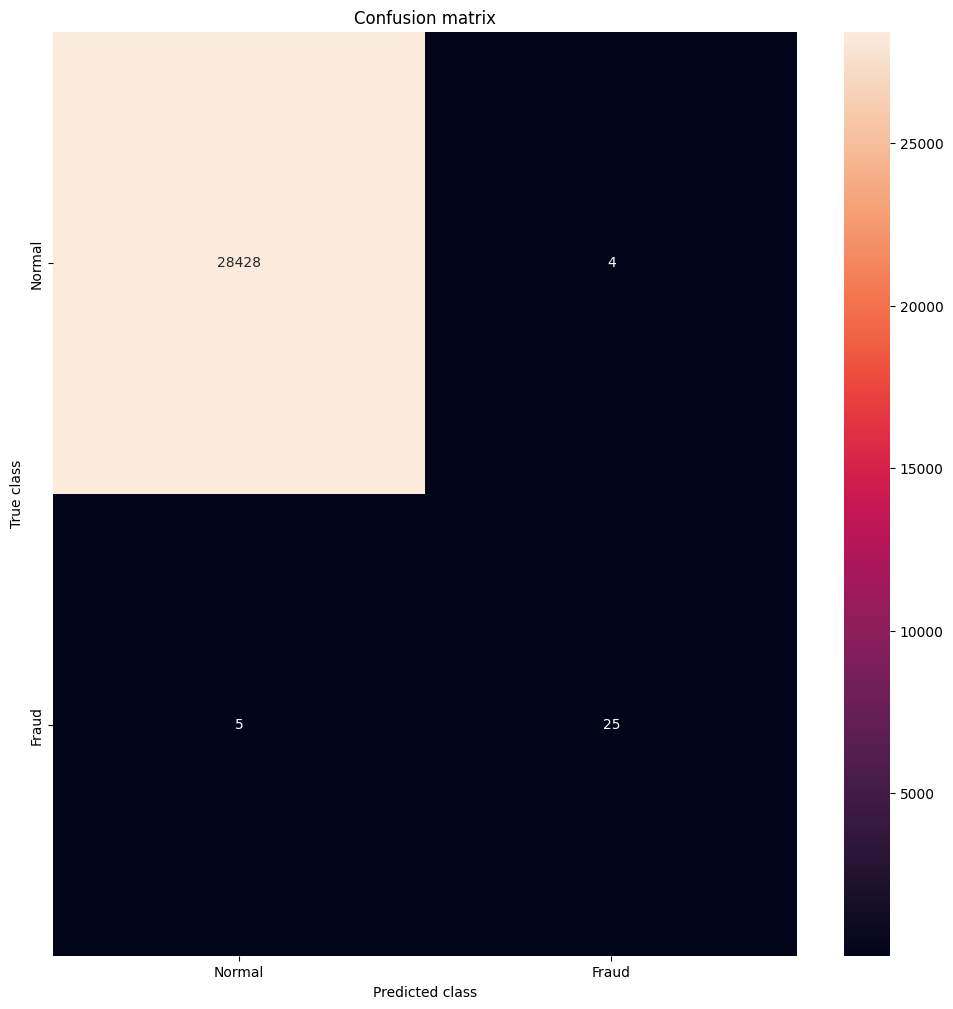

In [38]:
X_val = valid_df.drop(columns=['Class']) # Input Data
y_val = valid_df['Class'] # Label

val_pred, val_prob = get_pred_label(model, X_val, 29)
val_score = f1_score(y_val, val_pred, average='macro')
print(f'Validation F1 Score : [{val_score}]')
print(classification_report(y_val, val_pred))

conf_matrix = confusion_matrix(y_val, val_pred)
plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d")
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

# Inference

In [39]:
test_df = pd.read_csv('./test.csv')

In [40]:
X_test = test_df.drop(columns=['ID'])

In [41]:
test_pred, _ = get_pred_label(model, X_test, 315)
print('number of fraud: ', sum(test_pred))

number of fraud:  315


# Submission

In [42]:
submit = pd.read_csv('./sample_submission.csv')
submit['Class'] = test_pred
submit.to_csv('./elipticenvelope.csv', index=False)